In [1]:
# from osgeo import ogr
from shapely.geometry import MultiLineString, Polygon, MultiPolygon
from shapely import wkt
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pylab as pl
from functions.geograficas import *
from functions.cargar_data import *

In [2]:
# capa de deptos
deptos = gpd.read_file('capas/ine_deptos.gpkg')

# zonas 2011
zonas = gpd.read_file('capas/ine_zonas_11.gpkg')

# personas censo 96
personas96 = cargar_censo_96()

# personas censo 2011
# censo = pd.read_csv('tablas/personas_censo_2011.gz', compression='gzip',
#                     header=0, sep=',', quotechar='"')

cols = ['DPTO', 'LOC', 'SECC', 'SEGM','PERPH02']
censo = cargar_censo_vars(cols)

# carga capa de segmentos censales
seg = gpd.read_file('capas/ine_segm_11.gpkg')
seg['CODSEG'] = seg['CODSEG'].astype(str)
seg.drop_duplicates('CODSEG', inplace=True)
seg.shape

(4302, 12)

In [3]:
# calcula la población de cada segmento censal
poblacion = censo[cols].groupby(by=['DPTO','LOC', 'SECC', 'SEGM']).count()
poblacion.rename(columns={'PERPH02': 'poblacion'}, inplace=True)

poblacion.reset_index(inplace=True)

# genera cod seg
poblacion['CODSEG'] = get_codseg(poblacion)

print(poblacion.shape)
poblacion.head()

(4283, 6)


,DPTO,LOC,SECC,SEGM,poblacion,CODSEG
0,1,20,1,1,696,101001
1,1,20,1,2,660,101002
2,1,20,1,3,786,101003
3,1,20,1,104,882,101104
4,1,20,1,105,818,101105


In [4]:
poblacion.drop_duplicates('CODSEG', inplace=True)

In [5]:
pobl_seg = pd.merge(seg, poblacion, on='CODSEG')

### Ecuación del centro medio de población

$$
\overline{X}_w=\frac{\sum_{i=1}^{n}w_{i}X_{i}}{\sum_{i=1}^{n} w_{i}}
$$


$$
\overline{Y}_w=\frac{\sum_{i=1}^{n}w_{i}Y_{i}}{\sum_{i=1}^{n} w_{i}}
$$

## Centro medio de población 2011

In [6]:
xmean, ymean = centro_medio(pobl_seg, 'DPTO', 'poblacion')

In [7]:
mean_center_gdf = gpd.GeoDataFrame({'DEPTO': np.arange(1,20)},
                                   geometry=gpd.points_from_xy(xmean, ymean),
                                   crs= 'epsg:32721')

mean_center_gdf.head()

,DEPTO,geometry
0,1,POINT (575497.000 6141786.000)
1,2,POINT (517717.000 6636093.000)
2,3,POINT (587353.000 6159278.000)
3,4,POINT (777711.000 6409999.000)
4,5,POINT (431654.000 6211872.000)


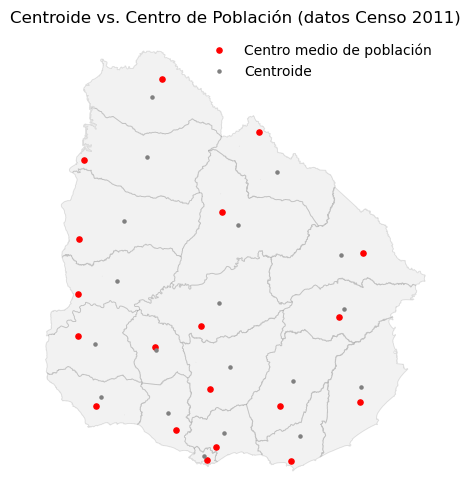

In [8]:
# plot de las capas de departamentos y localidades
plt.style.use('default')

f, ax = pl.subplots(figsize=(8,6))

# deptos
deptos.plot(linewidth = 0.7, edgecolor='black', color = 'grey', alpha=0.1, ax = ax)

# localidades
mean_center_gdf.plot(markersize=14, color = 'red', ax = ax, label='Centro medio de población')
deptos.geometry.centroid.plot(markersize=5, color = 'grey', ax = ax, label='Centroide')

# oculta ejes
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# hide spines
[ax.spines[i].set_visible(False) for i in ['right', 'top', 'left', 'bottom']]

# título
pl.title("Centroide vs. Centro de Población (datos Censo 2011)", size=12)

# referencias
plt.legend(frameon=False)

In [9]:
# # exporta geopaquete
# mean_center_gdf.to_file("capas/centro_poblacion.gpkg",
#                         layer='centro_de_poblacion', driver="GPKG")

In [13]:
# data para webmap
mean_center_webmap = mean_center_gdf.to_crs(4326).rename({'DEPTO': 'id'}, axis = 1)
mean_center_webmap['name'] = decode_depto_pretty(mean_center_webmap.id)
mean_center_webmap['lat'] = round(mean_center_webmap.geometry.y, 5)
mean_center_webmap['lon'] = round(mean_center_webmap.geometry.x, 5)
mean_center_webmap = mean_center_webmap.drop('geometry', axis=1)
mean_center_webmap.to_csv("webmap_flows/nodes.csv", index=False)

## Centro medio de población 1996

In [ ]:
capa_96 = zonas.merge(personas96, left_on='CODCOMP', right_on='CCOMP04', how='inner')
capa_96 = capa_96.loc[:, ['DEPTO', 'CODCOMP','CCOMP04','personas','geometry']]
capa_96.head()

In [ ]:
xmean, ymean = centro_medio(capa_96, 'DEPTO', 'personas')

In [ ]:
mean_center_gdf_96 = gpd.GeoDataFrame({'DEPTO': np.arange(1,20)},
                                   geometry=gpd.points_from_xy(xmean, ymean),
                                   crs= 'epsg:32721')

mean_center_gdf_96.head()

In [ ]:
# plot de las capas de departamentos y localidades
plt.style.use('default')

f, ax = pl.subplots(figsize=(8,6))

# deptos
deptos.plot(linewidth = 0.7, edgecolor='black', color = 'grey', alpha=0.1, ax = ax)

# localidades
mean_center_gdf.plot(markersize=14, color = 'red', ax = ax, label='Centro medio de población 2011')
mean_center_gdf_96.plot(markersize=14, color = 'blue', ax = ax, label='Centro medio de población 1996')
deptos.geometry.centroid.plot(markersize=5, color = 'grey', ax = ax, label='Centroide')

# oculta ejes
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# hide spines
[ax.spines[i].set_visible(False) for i in ['right', 'top', 'left', 'bottom']]

# título
pl.title("Centroide vs. Centros de Población (Censos 1996 y 2011)", size=12)

# referencias
# plt.legend(frameon=False)